# Data Analytics Project- Traffic Accident Duration Prediction Models

Prediction models for traffic accident clearance duration can be helpful in practice because by finding the underlying factors, those factors can be considered for transportation policies to improve highway safety. The purpose of this project is to identify relevant features that can potentially explain the duration of traffic accident clearance and build models for predicting traffic accident duration. Three types of regression models -DTR, RF, and GBT- were utilized to train on historical data and to predict the duration of traffic accident clearance on unseen data. To compare the performance of models, evaluations were made based on RMSE and MAE. 

In [1]:
# By Sujung Choi

<a id="0"></a> <br>
 # Table of Contents  
1. [Data Loading and Preprocessing](#1)
    1. [Feature Creation](#2)
    2. [Handling outliers using interquartile range](#3)
    3. [Handling missing data](#4)
    4. [Handling categorical values using StringIndexer](#5)
    5. [Exploratory Data Analysis with Data Visualization](#6)
    6. [Correlation Evaluation Using Correlation Heatmap](#7)
    7. [Handling categorical values using one hot encoding](#8)
    8. [Standardization of numerical features](#9)
1. [Training and Testing Models](#10) 
1. [Hyperparameter tuning](#11)    
1. [Result visualization](#12)         


<a id="1"></a> 
# 1. Data Loading and Preprocessing

In [ ]:
from pyspark.sql import SparkSession

# Initialize a SparkSession
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Read the Hive tables stored in Databricks into DataFrames
# because of the file size, the data was splitted into different files
table_name0 = "hive_metastore.default.chunk_0"
df_0 = spark.sql(f"SELECT * FROM {table_name0}")

table_name1 = "hive_metastore.default.chunk_1"
df_1 = spark.sql(f"SELECT * FROM {table_name1}")

table_name2 = "hive_metastore.default.chunk_2"
df_2 = spark.sql(f"SELECT * FROM {table_name2}")

table_name3 = "hive_metastore.default.chunk_3"
df_3 = spark.sql(f"SELECT * FROM {table_name3}")

table_name4 = "hive_metastore.default.chunk_4"
df_4 = spark.sql(f"SELECT * FROM {table_name4}")

table_name5 = "hive_metastore.default.chunk_5"
df_5 = spark.sql(f"SELECT * FROM {table_name5}")

table_name6 = "hive_metastore.default.chunk_6"
df_6 = spark.sql(f"SELECT * FROM {table_name6}")

table_name7 = "hive_metastore.default.chunk_7"
df_7 = spark.sql(f"SELECT * FROM {table_name7}")

# Append the DataFrames together
df = df_0.union(df_1).union(df_2).union(df_3).union(df_4).union(df_5).union(df_6).union(df_7)

In [3]:
# import necessary libraries
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler


In [4]:
seed=12

In [5]:
#to check how many rows and columns the dataset contains
num_rows = df.count()
print(f"The data frame contains {num_rows} number of rows.")
num_cols = len(df.columns)
print(f"The data frame contains {num_cols} number of columns.")


The data frame contains 7728394 number of rows.
The data frame contains 46 number of columns.


In [6]:
# display top five rows of each column to understand how the data looks like
df.select(df.columns[0:10]).show(5, truncate=False)


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+
|ID |Source |Severity|Start_Time         |End_Time           |Start_Lat        |Start_Lng         |End_Lat|End_Lng|Distance(mi)|
+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+
|A-1|Source2|3       |2016-02-08 05:46:00|2016-02-08 11:00:00|39.865147        |-84.058723        |null   |null   |0.01        |
|A-2|Source2|2       |2016-02-08 06:07:59|2016-02-08 06:37:59|39.92805900000001|-82.831184        |null   |null   |0.01        |
|A-3|Source2|2       |2016-02-08 06:49:27|2016-02-08 07:19:27|39.063148        |-84.032608        |null   |null   |0.01        |
|A-4|Source2|3       |2016-02-08 07:23:34|2016-02-08 07:53:34|39.747753        |-84.20558199999998|null   |null   |0.01        |
|A-5|Source2|2       |2016-02-08 07:39:07|2016-02-08 08:09:07|39.627781        |-84.188354       

In [7]:
df.select(df.columns[10:20]).show(5, truncate=False)


+-------------------------------------------------------------------------------------+-------------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+
|Description                                                                          |Street                   |City        |County    |State|Zipcode   |Country|Timezone  |Airport_Code|Weather_Timestamp  |
+-------------------------------------------------------------------------------------+-------------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+
|Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.|I-70 E                   |Dayton      |Montgomery|OH   |45424     |US     |US/Eastern|KFFO        |2016-02-08 05:58:00|
|Accident on Brice Rd at Tussing Rd. Expect delays.                                   |Brice Rd                 |Reynoldsburg|Franklin  |OH   |43068-3402|US     |US/Eastern

In [8]:
df.select(df.columns[20:30]).show(5, truncate=False)

+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+
|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|
+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+
|36.9          |null         |91.0       |29.68       |10.0          |Calm          |null           |0.02             |Light Rain       |false  |
|37.9          |null         |100.0      |29.65       |10.0          |Calm          |null           |0.0              |Light Rain       |false  |
|36.0          |33.3         |100.0      |29.67       |10.0          |SW            |3.5            |null             |Overcast         |false  |
|35.1          |31.0         |96.0       |29.64       |9.0           |SW            |4.6            |null             |Mostl

In [9]:
df.select(df.columns[30:40]).show(5, truncate=False)

+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+
|Bump |Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop |Traffic_Calming|
+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+
|false|false   |false   |false   |false  |false  |false     |false  |false|false          |
|false|false   |false   |false   |false  |false  |false     |false  |false|false          |
|false|false   |false   |false   |false  |false  |false     |false  |false|false          |
|false|false   |false   |false   |false  |false  |false     |false  |false|false          |
|false|false   |false   |false   |false  |false  |false     |false  |false|false          |
+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+
only showing top 5 rows



In [10]:
df.select(df.columns[40:]).show(5, truncate=False)

+--------------+------------+--------------+--------------+-----------------+---------------------+
|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+--------------+------------+--------------+--------------+-----------------+---------------------+
|false         |false       |Night         |Night         |Night            |Night                |
|false         |false       |Night         |Night         |Night            |Day                  |
|true          |false       |Night         |Night         |Day              |Day                  |
|false         |false       |Night         |Day           |Day              |Day                  |
|true          |false       |Day           |Day           |Day              |Day                  |
+--------------+------------+--------------+--------------+-----------------+---------------------+
only showing top 5 rows



In [11]:
df.dtypes

[('ID', 'string'),
 ('Source', 'string'),
 ('Severity', 'int'),
 ('Start_Time', 'timestamp'),
 ('End_Time', 'timestamp'),
 ('Start_Lat', 'double'),
 ('Start_Lng', 'double'),
 ('End_Lat', 'double'),
 ('End_Lng', 'double'),
 ('Distance(mi)', 'double'),
 ('Description', 'string'),
 ('Street', 'string'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Zipcode', 'string'),
 ('Country', 'string'),
 ('Timezone', 'string'),
 ('Airport_Code', 'string'),
 ('Weather_Timestamp', 'timestamp'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Direction', 'string'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Weather_Condition', 'string'),
 ('Amenity', 'boolean'),
 ('Bump', 'boolean'),
 ('Crossing', 'boolean'),
 ('Give_Way', 'boolean'),
 ('Junction', 'boolean'),
 ('No_Exit', 'boolean'),
 ('Railway', 'boolean'),
 ('Roundabout', 'boolean'),
 ('Station

In [12]:
# Initially I chose 19 features to analyze and excluded the features that have too many null values
# (e.g. 'End_Lat' and 'End_Lng' have almost 50% of the values with null values)
selected_df = df.select(
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Street',
 'City',
 'County',
 'State',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Sunrise_Sunset')


<a id="2"></a> 
# A. Feature Creation

In [13]:
# calculate the duration in minutes and create a new column with that feature
selected_df = selected_df.withColumn("Duration", ((unix_timestamp("End_Time") - unix_timestamp("Start_Time"))/60))

# Show the results
selected_df.select("Start_Time", "End_Time", "Duration").show()


+-------------------+-------------------+--------+
|         Start_Time|           End_Time|Duration|
+-------------------+-------------------+--------+
|2016-02-08 05:46:00|2016-02-08 11:00:00|   314.0|
|2016-02-08 06:07:59|2016-02-08 06:37:59|    30.0|
|2016-02-08 06:49:27|2016-02-08 07:19:27|    30.0|
|2016-02-08 07:23:34|2016-02-08 07:53:34|    30.0|
|2016-02-08 07:39:07|2016-02-08 08:09:07|    30.0|
|2016-02-08 07:44:26|2016-02-08 08:14:26|    30.0|
|2016-02-08 07:59:35|2016-02-08 08:29:35|    30.0|
|2016-02-08 07:59:58|2016-02-08 08:29:58|    30.0|
|2016-02-08 08:00:40|2016-02-08 08:30:40|    30.0|
|2016-02-08 08:10:04|2016-02-08 08:40:04|    30.0|
|2016-02-08 08:14:42|2016-02-08 08:44:42|    30.0|
|2016-02-08 08:21:27|2016-02-08 08:51:27|    30.0|
|2016-02-08 08:36:34|2016-02-08 09:06:34|    30.0|
|2016-02-08 08:37:07|2016-02-08 09:07:07|    30.0|
|2016-02-08 08:39:43|2016-02-08 09:09:43|    30.0|
|2016-02-08 08:43:20|2016-02-08 09:13:20|    30.0|
|2016-02-08 08:53:17|2016-02-08

<a id="3"></a> 
# B. Handling outliers using interquartile range

In [14]:
def IQR_method(df_name, col_name):
    # to find outliers using IQR methods
    quartiles = df_name.approxQuantile(col_name, [0.25, 0.75], 0.01)
    
    Q1 = quartiles[0]
    print("Q1: ", Q1)
    
    Q3 = quartiles[1]
    print("Q3: ", Q3)
    
    IQR = Q3 - Q1
    
    lowerBound = Q1 - 1.5 * IQR
    print("lower bound: ", lowerBound)
    
    upperBound = Q3 + 1.5 * IQR
    print("upper bound: ", upperBound)

    outliers_df = df_name.filter((col(col_name) < lowerBound) | (col(col_name) > upperBound))
    print("number of outliers: ", outliers_df.count())
    
    print("percentage of outliers from the dataset: ", (outliers_df.count()/df_name.count()) * 100)

    #removing the outliers from the dataset
    filtered_df = df_name.filter((col(col_name) > lowerBound) & (col(col_name) < upperBound))
    print("number of rows after removing outliers: ", filtered_df.count())

    return filtered_df

In [15]:
selected_df.select("Duration").summary().show()

+-------+------------------+
|summary|          Duration|
+-------+------------------+
|  count|           7728394|
|   mean| 444.4281537104159|
| stddev|13512.294803517478|
|    min|1.2166666666666666|
|    25%|              31.5|
|    50%| 74.83333333333333|
|    75%|            125.15|
|    max|         2812999.0|
+-------+------------------+



In [16]:
#remove outliers for "Duration" column which will be our target variable
removed_duration_df = IQR_method(selected_df, "Duration")


Q1:  31.0
Q3:  124.91666666666667
lower bound:  -109.875
upper bound:  265.7916666666667
number of outliers:  731701
percentage of outliers from the dataset:  9.467697946041572
number of rows after removing outliers:  6996693


In [17]:
removed_duration_df.select("Distance(mi)").summary().show()

+-------+------------------+
|summary|      Distance(mi)|
+-------+------------------+
|  count|           6996693|
|   mean|0.4966252302433074|
| stddev|1.6363750038853613|
|    min|               0.0|
|    25%|               0.0|
|    50%|              0.01|
|    75%|0.3720000000000001|
|    max|336.57000732421875|
+-------+------------------+



array([[<Axes: title={'center': 'Distance(mi)'}>]], dtype=object)

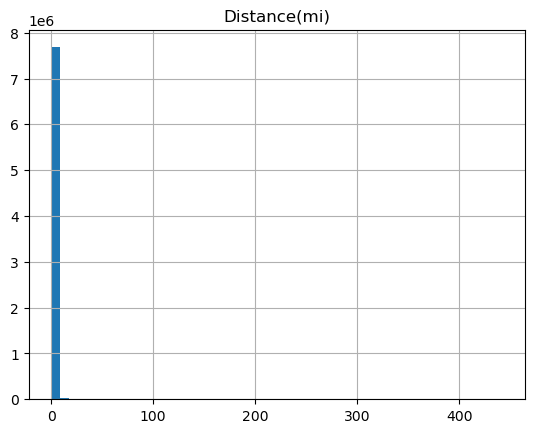

In [18]:
df.select("Distance(mi)").toPandas().hist(bins=50)

In [19]:
#remove outliers for "Distance(mi)" because it is highly skewed to the left (less than 1 mile)
outliers_removed_df = IQR_method(removed_duration_df, "Distance(mi)")


Q1:  0.0
Q3:  0.371
lower bound:  -0.5565
upper bound:  0.9275
number of outliers:  994109
percentage of outliers from the dataset:  14.208269535336193
number of rows after removing outliers:  6002584


In [20]:
outliers_removed_df.select('Visibility(mi)').summary().show()

#keep visibility that are less than 20 only because the majority is skewed to the left (less than 10 miles)
removed_visibil_df = outliers_removed_df.filter(col('Visibility(mi)') < 20)

print("number of rows after removing outliers: ", removed_visibil_df.count())

+-------+------------------+
|summary|    Visibility(mi)|
+-------+------------------+
|  count|           5873622|
|   mean| 9.118767130401004|
| stddev|2.6426041276757872|
|    min|               0.0|
|    25%|              10.0|
|    50%|              10.0|
|    75%|              10.0|
|    max|             140.0|
+-------+------------------+

number of rows after removing outliers:  5862519


In [21]:
#count nulls in each column and display the results
null_counts = removed_visibil_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in removed_visibil_df.columns])
null_counts.show(truncate=False)


+--------+----------+--------+---------+---------+------------+------+----+------+-----+-----------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+--------+
|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Street|City|County|State|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Duration|
+--------+----------+--------+---------+---------+------------+------+----+------+-----+-----------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+--------+
|0       |0         |0       |0        |0        |0           |8423  |144 |0     |0    |0                |19259         |1459170      |26849      |6727        |0             |337381         |1627541          |12882         |0       |
+--------+----------+--------+---------+---------+------------+-

<a id="4"></a> 
# C. Handling missing data

In [22]:
# handling missing values in columns

#set the window spec to be in the timely order based on the weather timestamp recording the time when the weather data was observed
window_spec = Window.orderBy('Weather_Timestamp')

def handle_missing_values(col_name, df_name, window_spec):

    column = df_name[col_name]
    #calculate the average value of the column
    avg_value = df_name.select(avg(col_name)).collect()[0][0]

    #when there are missing values, replace the null values according to the following conditions:
    #1) use the previous value from the lag function when it is available
    #2) use the next value from the lead function when it is available
    #3) use the constant of average value from lit function when none of the previous or next values are available
    #otherwise, when it is not null, keep the value as it is
    result_df = df_name.withColumn(col_name, 
                                    when(isnull(column), 
                                        coalesce(lag(column).over(window_spec), 
                                                lead(column).over(window_spec),
                                                lit(avg_value))).otherwise(column))
    
    return result_df
    

In [23]:
# fill the missing values in 'Temperature(F)'
filtered_temp = handle_missing_values('Temperature(F)', removed_visibil_df, window_spec)


In [24]:
# as Sunrise_Sunset column contains categorical data (i.e., Day or Night based on Sunrise and Sunset),
# we will use forward filling method to fill missing values by replacing it with previous data.
# if there is a null value, replace with a previous non-null value.
filtered_sun = filtered_temp.withColumn("Sunrise_Sunset", last("Sunrise_Sunset", ignorenulls=True).over(window_spec))


In [25]:
# Weather_Timestamp was used for window spec but will not be used further, so drop here
#as we did calculate and create Duration column already, End_Time also can be dropped as it will not be used further
selected_cols_df = filtered_sun.drop("Weather_Timestamp", "End_Time")

#check again nulls
null_counts = selected_cols_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in selected_cols_df.columns])
null_counts.show(truncate=False)


+--------+----------+---------+---------+------------+------+----+------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+--------+
|Severity|Start_Time|Start_Lat|Start_Lng|Distance(mi)|Street|City|County|State|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Duration|
+--------+----------+---------+---------+------------+------+----+------+-----+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+--------+
|0       |0         |0        |0        |0           |8423  |144 |0     |0    |0             |1459170      |26849      |6727        |0             |337381         |1627541          |0             |0       |
+--------+----------+---------+---------+------------+------+----+------+-----+--------------+-------------+-----------+------------+--------------+---------------+--------

In [26]:
# Extract time features from Start_Time
transformed_df = selected_cols_df.withColumn("hour", hour("Start_Time")).withColumn("day_of_week", dayofweek("Start_Time")).withColumn("month", month("Start_Time")).withColumn("year", year("Start_Time")).withColumn("day_of_month", dayofmonth("Start_Time"))

transformed_df = transformed_df.drop("Start_Time")

In [27]:
# check the number of accidents per year
transformed_df.groupBy("year").count().orderBy("year").show()

+----+-------+
|year|  count|
+----+-------+
|2016| 272557|
|2017| 515617|
|2018| 746827|
|2019| 862652|
|2020| 939644|
|2021|1122279|
|2022|1230398|
|2023| 172545|
+----+-------+



In [28]:
# drop the year 2023 as it contains only the first three months of that year (January through March) which does not 
# provide the full information of that year.
removed_year_df = transformed_df.filter(col("year") < 2023)
removed_year_df.count()

5689974

In [29]:
# as only 183 rows have null values in column 'City' which won't affect the result, it is decided to simply drop those rows.
removed_city_df = removed_year_df.filter(removed_year_df['City'].isNotNull())

# likewise, drop 'Street' that contains nulls because it is not reasonable to randomly fill them and it is a relatively small proportion of the dataset
removed_street_df = removed_city_df.filter(removed_city_df['Street'].isNotNull())


In [30]:
removed_street_df.count()

5682003

In [31]:
removed_street_df.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Sunrise_Sunset: string (nullable = true)
 |-- Duration: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)



<a id="5"></a> 
# D. Handling categorical values using StringIndexer

In [36]:

string_cols = ['Street', 'City', 'County', 'State', 'Sunrise_Sunset']
stages = []
for val in string_cols:
    # StringIndexer to index the column
    string_indexer = StringIndexer(inputCol=val, outputCol=f"{val}_indexed")
    stages.append(string_indexer)

pipeline = Pipeline(stages=stages)
model = pipeline.fit(removed_street_df).transform(removed_street_df)

model = model.drop(*string_cols)


In [37]:
model.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Duration: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- Street_indexed: double (nullable = false)
 |-- City_indexed: double (nullable = false)
 |-- County_indexed: double (nullable = false)
 |-- State_indexed: double (nullable = false)
 |-- Sunrise_Sunset_indexed: double (nullable = false)



<a id="6"></a> 
# E. Exploratory Data Analysis with Data Visualization

In [41]:
#Severity: It describes a degree of severity of the accident with a number between 1 and 4,
# where the higher the degree, the severe the accident was.
# 1 indicates the impact on traffic caused by the accident was the least (i.e., short delay) 
# and 4 indicates a significant impact on traffic (i.e., long delay).

import matplotlib.pyplot as plt
from pyspark.sql.functions import count

def severity_plot(df):
    severity_counts = df.groupBy('Severity').agg(count('*').alias('count')).orderBy('Severity')

    # Convert the spark df to a pandas df for plotting
    severity_counts_pd = severity_counts.toPandas()

    # create a bar plot
    plt.bar(severity_counts_pd['Severity'], severity_counts_pd['count'])

    plt.xlabel('Severity')
    plt.ylabel('Count')
    plt.title('Distribution of Traffic Accident Severity')

    plt.show()

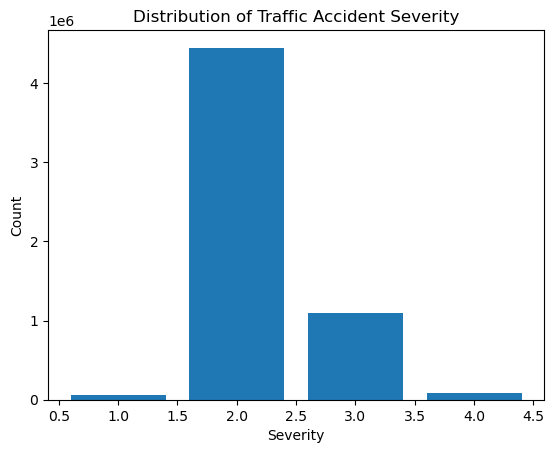

In [42]:
severity_plot(removed_year_df)

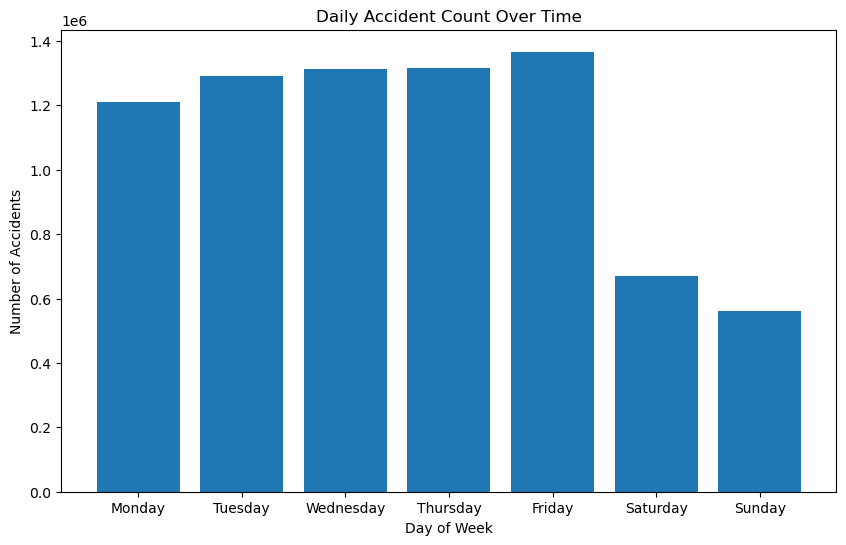

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the date from the timestamp in 'Start_Time' column and create a new column for the accident date

dayOfWeek = df.select(date_format(df.Start_Time, "EEEE").alias("Day"))

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by Day to count the number of accident for each day
num_accidents_per_day = dayOfWeek.groupBy('Day').count().orderBy('Day')

# convert df to pandas to visualize the results
num_accidents_per_day_pd = num_accidents_per_day.toPandas()

# Use Categorical data type to set the specific day order
num_accidents_per_day_pd['Day'] = pd.Categorical(num_accidents_per_day_pd['Day'], categories=day_order, ordered=True)

# Sort DataFrame based on the typical order of a week
num_accidents_per_day_pd = num_accidents_per_day_pd.sort_values('Day')

# plot the graph for the number of accidents per day
plt.figure(figsize=(10, 6))
plt.bar(num_accidents_per_day_pd['Day'], num_accidents_per_day_pd['count'])
plt.title('Daily Accident Count Over Time')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.show()

# It shows that the accidents are mostly happening during weekdays rather than weekends.

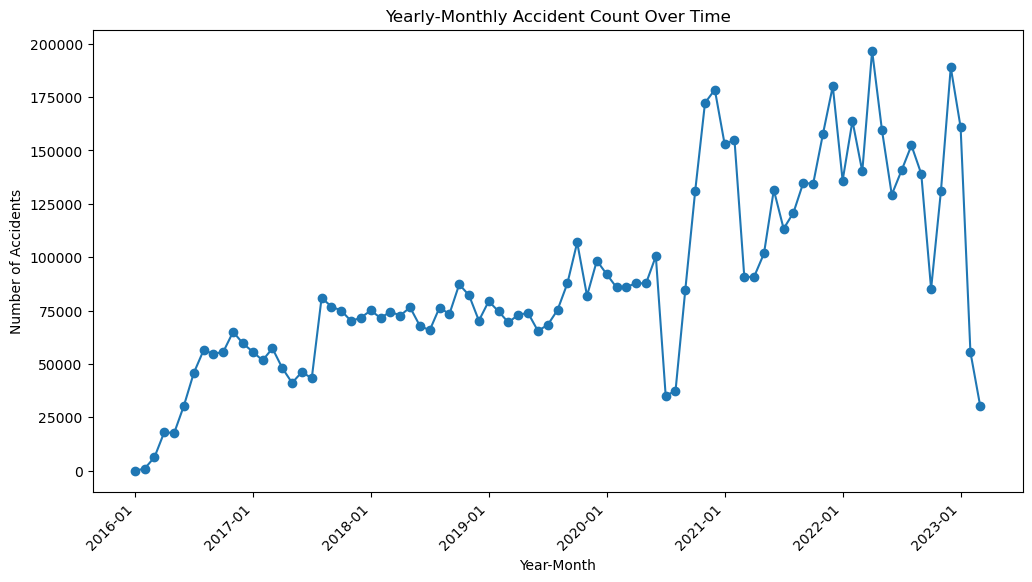

In [45]:
# Extract the year-month from the timestamp in 'Start_Time' column
temp_df = df.withColumn("Year_Month", date_format(col("Start_Time"), "yyyy-MM"))

# Group by Year_Month to count the number of accidents for each month over time
num_accidents_per_year_month = temp_df.groupBy("Year_Month").count().orderBy("Year_Month")

# Convert df to pandas to visualize the results
num_accidents_per_year_month_pd = num_accidents_per_year_month.toPandas()

# Plot the graph for the number of accidents per each Year-Month
plt.figure(figsize=(12, 6))
plt.plot(num_accidents_per_year_month_pd['Year_Month'], num_accidents_per_year_month_pd['count'], marker='o', linestyle='-')
plt.title('Yearly-Monthly Accident Count Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Accidents')

#select every 12th element as the time range is too long to show in the xticks
plt.xticks(num_accidents_per_year_month_pd['Year_Month'][::12], rotation=45, ha="right")

plt.show()

# Even though there are some fluctuations, the general view of the graph shows an increasing pattern for the number of accidents over time from 2016 to 2023,
# except for the unprecedented low point in the middle of 2020 because of the global pandemic.

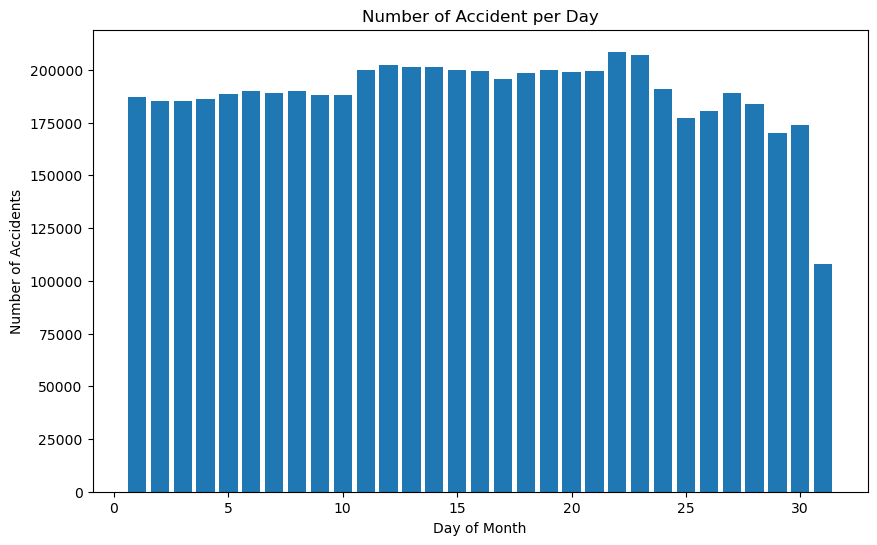

In [46]:
import matplotlib.pyplot as plt

# Group by day_of_month to count the number of accident for the day of month (i.e., 1 - 31)
count_day = transformed_df.groupBy('day_of_month').count().orderBy("day_of_month")
# convert df to pandas to visualize the results
count_day_pd = count_day.toPandas()

#plot the graph for the number of accidents per day in a month
plt.figure(figsize=(10, 6))
plt.bar(count_day_pd['day_of_month'], count_day_pd['count'])
plt.title('Number of Accident per Day')
plt.xlabel('Day of Month')
plt.ylabel('Number of Accidents')
plt.show()

# The graph shows there are no distinct patterns/differences between days of the month. So I will not use this feature.

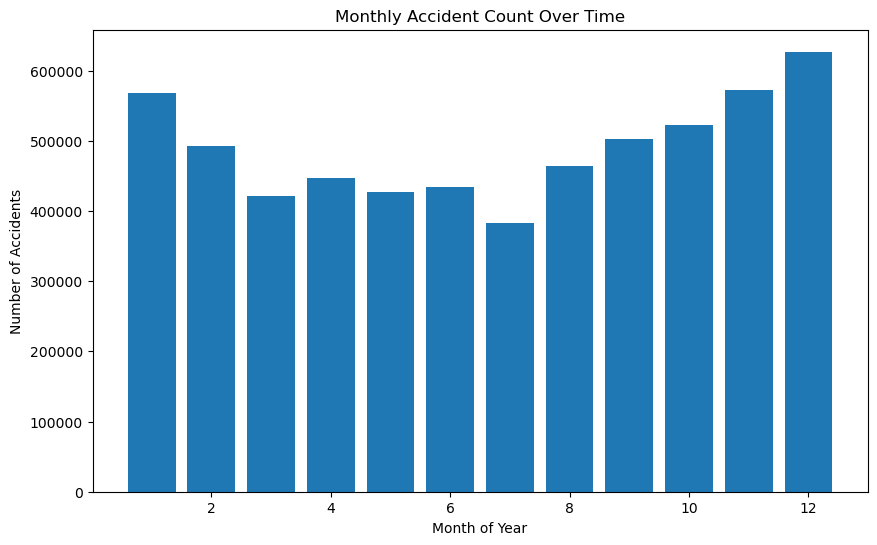

In [47]:
import matplotlib.pyplot as plt

# Group by month to count the number of accident for each month
num_accidents_per_month = transformed_df.groupBy('month').count().orderBy("month")
# convert df to pandas to visualize the results
num_accidents_per_month_pd = num_accidents_per_month.toPandas()

#plot the graph for the number of accidents per day
plt.figure(figsize=(10, 6))
plt.bar(num_accidents_per_month_pd['month'], num_accidents_per_month_pd['count'])
plt.title('Monthly Accident Count Over Time')
plt.xlabel('Month of Year')
plt.ylabel('Number of Accidents')
plt.show()

# The graph shows November, December, and January have the highest number of accidents, 
# and it appears to have fewer accidents in summer (July is the lowest).

<a id="7"></a> 
# F. Correlation Evaluation Using Correlation Heatmap

In [39]:

# Define the features
feature_cols = ['Severity',
'Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Duration',
 'hour',
 'day_of_week',
 'month',
 'year',
 'day_of_month',
 'Street_indexed',
 'City_indexed',
 'County_indexed',
 'State_indexed',
 'Sunrise_Sunset_indexed']

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip") 
prepared_df = assembler.transform(model)

corr_matrix = Correlation.corr(prepared_df, "features").head()
corr_matrix = corr_matrix[0].toArray()

corr_matrix_df = pd.DataFrame(corr_matrix, columns=feature_cols, index=feature_cols)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(corr_matrix_df)

                        Severity  Start_Lat  Start_Lng  Distance(mi)  \
Severity                1.000000   0.080354   0.063580     -0.080604   
Start_Lat               0.080354   1.000000  -0.094579      0.039689   
Start_Lng               0.063580  -0.094579   1.000000      0.010046   
Distance(mi)           -0.080604   0.039689   0.010046      1.000000   
Temperature(F)         -0.032109  -0.449528   0.005065     -0.021932   
Wind_Chill(F)          -0.035511  -0.453388  -0.010192     -0.023498   
Humidity(%)             0.017845   0.002767   0.191286     -0.025847   
Pressure(in)           -0.025997  -0.243000   0.225108     -0.009621   
Visibility(mi)         -0.030368  -0.121841   0.000104      0.005141   
Wind_Speed(mph)         0.031010   0.018974   0.090974      0.014863   
Precipitation(in)       0.018448  -0.008768   0.029864     -0.001349   
Duration               -0.094843   0.008223  -0.052620      0.103901   
hour                    0.023014  -0.019162   0.002904      0.05

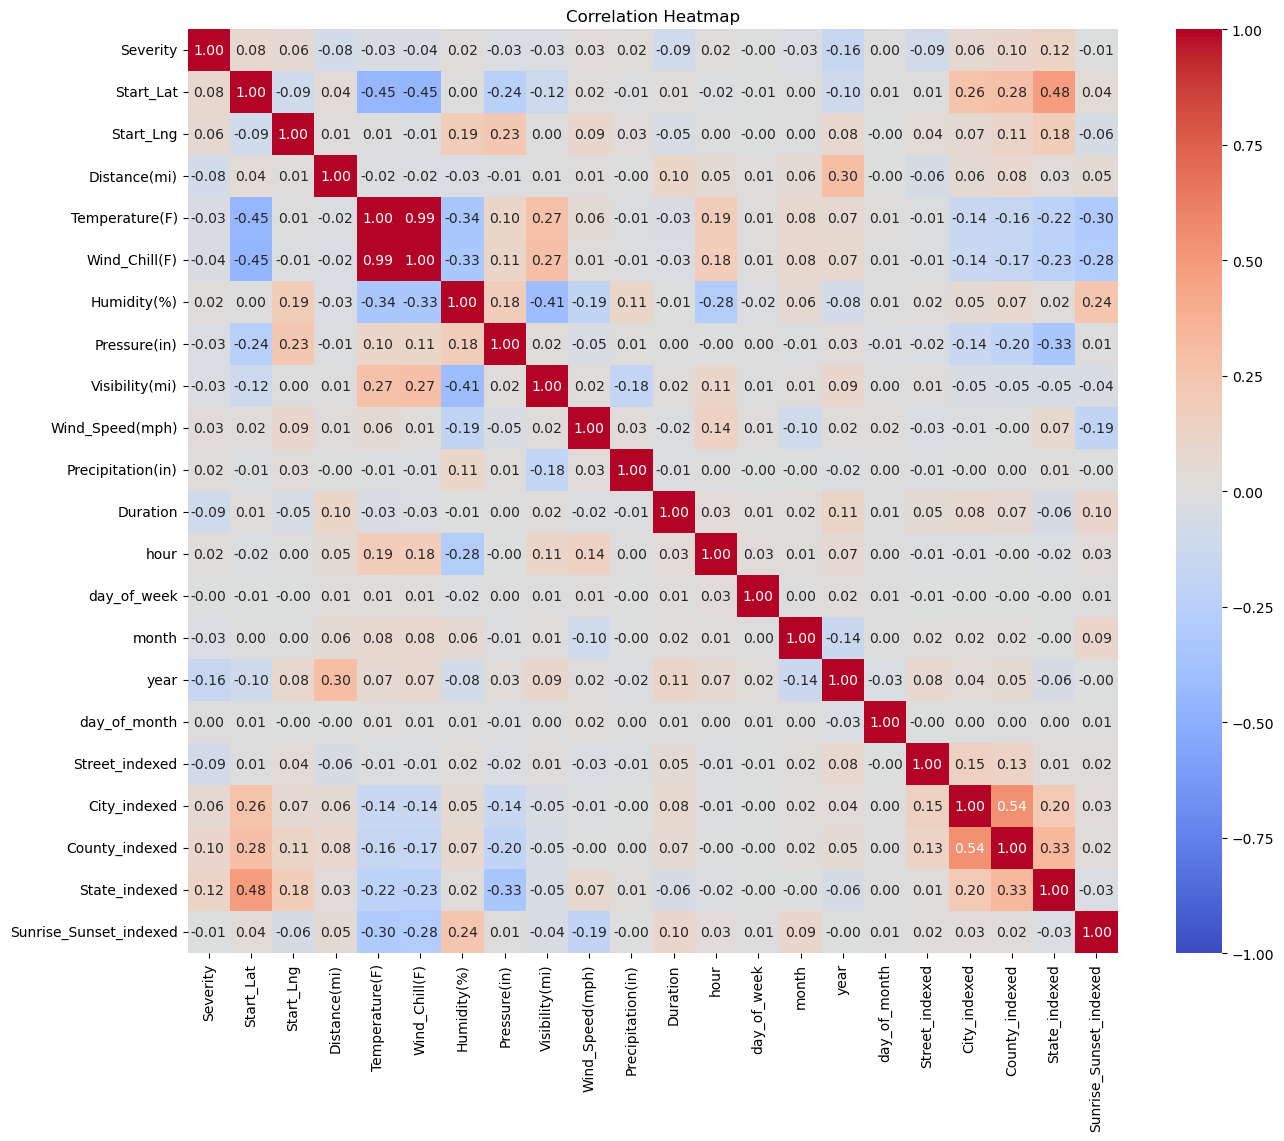

In [40]:

plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix_df, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# Based on the result, it shows there are not many features that have a strong correlation with Duration.
# But it only shows the linear relationships so we cannot determine the non-linear relationships.
# Therefore, by considering all results we have observed through EDA, I select "severity, distance, temperature, start_lat,
# start_lng, visibility, sunrise_sunset, hour, day_of_week, month, year" as the independent variables to be used in the predictive models.

<a id="8"></a> 
# G. Handling categorical values using one hot encoding

In [ ]:
new_df = model.select('Severity', "Start_Lat", "Start_Lng", 'Distance(mi)', 'Temperature(F)', 'Visibility(mi)', 'Duration', 'Sunrise_Sunset_indexed','hour','day_of_week','month','year')

In [ ]:

categorical_cols = ['Severity','hour','day_of_week','month','year']
# I treat time-related features as categorical here because they do not have a linear relationship; 
# each day of week, each month, each year are more like categories.
# even using them as numerical values and conducting experiments, it was observed that they perform better when treated as categorical features.
stages = []

for val in categorical_cols:
    encoder = OneHotEncoder(inputCol=val, outputCol=f"{val}_encoded")
    stages.append(encoder)

pipeline = Pipeline(stages=stages)
onehot_df = pipeline.fit(new_df).transform(new_df)

onehot_df = onehot_df.drop(*categorical_cols)



Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

<a id="9"></a> 
# H. Standardization of numerical features

In [ ]:

numeric_cols = ["Start_Lat", "Start_Lng", 'Distance(mi)', 'Temperature(F)', 'Visibility(mi)']
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='numeric_features')
scaler = StandardScaler(inputCol='numeric_features', outputCol='scaled_features')

pipeline_numeric = Pipeline(stages=[assembler, scaler])
transformed_df_numeric = pipeline_numeric.fit(onehot_df).transform(onehot_df)





Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
transformed_df_numeric.printSchema()

In [ ]:
transformed_df_numeric.select("scaled_features").show(truncate=False)

In [ ]:
feature_cols = ['scaled_features', 'Sunrise_Sunset_indexed', 'Severity_encoded', 'hour_encoded','day_of_week_encoded','month_encoded','year_encoded']

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
prepared_df = assembler.transform(transformed_df_numeric)

In [ ]:
prepared_df = prepared_df.withColumnRenamed("Duration", "label")


In [ ]:
df_for_regression = prepared_df.select("label", "features")
df_for_regression.show(truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                     |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
|30.0 |(2074,[0,1,2,3,4,5,8,16,35,42,2068],[7.934490783552333,-4.798026143657379,0.04770741800144333,2.0364391605230496,4.392841175193907,1.0,1.0,1.0,1.0,1.0,1.0]) |
|30.0 |(2074,[0,1,2,3,4,5,8,16,35,42,2068],[7.762615953421142,-4.867619061242831,0.04770741800144333,1.9343485429770393,4.392841175193907,1.0,1.0,1.0,1.0,1.0,1.0]) |
|30.0 |(2074,[0,1,2,3,4,5,9,17,35,42,2068],[7.89866043439313,-4.8776386424451585,0.04770741800144333,1.8859898294026132,3.9535570576745167,1.0,1.0,1.0,1.0,1.0,1.0])|
|30.

In [ ]:
#after shuffling, extract 10% of df to reduce the time of training
shuffled_df = df_for_regression.orderBy(rand()) 
small_subset = shuffled_df.sample(fraction=0.1, seed=seed) 

sample_train, sample_test = small_subset.randomSplit([0.8, 0.2], seed=seed)

<a id="10"></a> 
# 2. Training and Testing Models

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="label", predictionCol="prediction")


#Baseline models

In [ ]:
#basic models using default parameters
dtr = DecisionTreeRegressor(featuresCol='features', labelCol='label').setSeed(seed)
rf = RandomForestRegressor(featuresCol='features', labelCol='label').setSeed(seed)
gbt = GBTRegressor(featuresCol='features', labelCol='label').setSeed(seed)

In [ ]:
#DTR

# Fit the model on the training data
dtr_model = dtr.fit(sample_train)

# Make predictions on the test data
dtr_predictions = dtr_model.transform(sample_test)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

dtr_MAE = mae_evaluator.evaluate(dtr_predictions)
print("DTR model MAE result on test data = %g" % dtr_MAE)
 
dtr_RMSE = rmse_evaluator.evaluate(dtr_predictions)
print("DTR model RMSE result on test data = %g" % dtr_RMSE)

DTR model MAE result on test data = 27.6169
DTR model RMSE result on test data = 39.442


In [ ]:
#RF

# Fit the model on the training data
rf_model = rf.fit(sample_train)

# Make predictions on the test data
rf_predictions = rf_model.transform(sample_test)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Evaluate the RF model
rf_MAE = mae_evaluator.evaluate(rf_predictions)
print("RF model MAE result on test data = %g" % rf_MAE)

rf_RMSE = rmse_evaluator.evaluate(rf_predictions)
print("RF model RMSE result on test data = %g" % rf_RMSE)
 

RF model MAE result on test data = 28.0841
RF model RMSE result on test data = 39.3954


In [ ]:
#GBT

# Fit the model on the training data
gbt_model = gbt.fit(sample_train)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(sample_test)


In [ ]:
# Evaluate the GBT model

gbt_MAE = mae_evaluator.evaluate(gbt_predictions)
print("GBT model MAE result on test data = %g" % gbt_MAE)

gbt_RMSE = rmse_evaluator.evaluate(gbt_predictions)
print("GBT model RMSE result on test data = %g" % gbt_RMSE)
 

<a id="11"></a> 
# 3. Hyperparameter tuning

In [ ]:

#DTR
dtr_param_grid = ParamGridBuilder().addGrid(dtr.maxDepth, [10, 15]).addGrid(dtr.maxBins, [40, 60]).build()

dtr_tvs = TrainValidationSplit(estimator=dtr,
                              estimatorParamMaps=dtr_param_grid,
                              evaluator=rmse_evaluator,
                              trainRatio=0.8,
                               seed=seed
                              )    
# Fit the model on the training data
dtr_tuned_model = dtr_tvs.fit(sample_train)

# Make predictions on the test data
tuned_dtr_predictions = dtr_tuned_model.transform(sample_test)

# Get the best model
dtr_best_model = dtr_tuned_model.bestModel


In [ ]:
# after running the above code, it was found that MaxDepth=15 and MaxBins=60 gave the best result among the given hyperparameters,
# so it was directly set to those numbers in this code to save the training time

tuned_dtr = dtr.setMaxDepth(15).setMaxBins(60)
# Fit the model on the training data
dtr_tuned_model = tuned_dtr.fit(sample_train)

# Make predictions on the test data
tuned_dtr_predictions = dtr_tuned_model.transform(sample_test)
   

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

tuned_dtr_MAE = mae_evaluator.evaluate(tuned_dtr_predictions)
print("Best DTR model MAE on test data = %g" % tuned_dtr_MAE)

tuned_dtr_RMSE = rmse_evaluator.evaluate(tuned_dtr_predictions)
print("Best DTR model RMSE on test data = %g" % tuned_dtr_RMSE)

Best DTR model MAE on test data = 23.4732
Best DTR model RMSE on test data = 35.2183


In [ ]:

#RF

rf_param_grid = ParamGridBuilder().addGrid(rf.maxDepth, [10, 15]).addGrid(rf.maxBins, [40, 60]).build()

rf_tvs = TrainValidationSplit(estimator=rf,
                              estimatorParamMaps=rf_param_grid,
                              evaluator=rmse_evaluator,
                              trainRatio=0.8,
                              seed=seed
                              )    
# Fit the model on the training data

rf_tuned_model = rf_tvs.fit(sample_train)

# Make predictions on the test data
tuned_rf_predictions = rf_tuned_model.transform(sample_test)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

tuned_rf_MAE = mae_evaluator.evaluate(tuned_rf_predictions)
print("Best RF model MAE on test data = %g" % tuned_rf_MAE)

tuned_rf_RMSE = rmse_evaluator.evaluate(tuned_rf_predictions)
print("Best RF model RMSE on test data = %g" % tuned_rf_RMSE)


Best RF model MAE on test data = 23.853
Best RF model RMSE on test data = 34.7114


In [ ]:
#GBT

gbt_param_grid = ParamGridBuilder().addGrid(gbt.maxDepth, [10, 15]).addGrid(gbt.maxIter, [20, 30]).build()
gbt_tvs = TrainValidationSplit(estimator=gbt,
                              estimatorParamMaps=gbt_param_grid,
                              evaluator=rmse_evaluator,
                              trainRatio=0.8,
                               seed=seed
                              )    

# Fit the model on the training data
gbt_tuned_model = gbt_tvs.fit(sample_train)

# Make predictions on the test data
gbt_predictions = gbt_tuned_model.transform(sample_test)
    

# Get the best model
gbt_best_model = gbt_tuned_model.bestModel


In [ ]:
# after running the above code, it was found that MaxDepth=15 and MaxIter=30 gave the best result among the given hyperparameters,
# so it was directly set to those numbers in this code to save the training time

tuned_gbt = gbt.setMaxDepth(15).setMaxIter(30)
# Fit the model on the training data
gbt_tuned_model = tuned_gbt.fit(sample_train)

# Make predictions on the test data
tuned_gbt_predictions = gbt_tuned_model.transform(sample_test)
   

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_gbt_MAE = mae_evaluator.evaluate(tuned_gbt_predictions)
print("Best GBT model MAE on test data = %g" % tuned_gbt_MAE)

tuned_gbt_RMSE = rmse_evaluator.evaluate(tuned_gbt_predictions)
print("Best GBT model RMSE on test data = %g" % tuned_gbt_RMSE)


Best GBT model MAE on test data = 20.86
Best GBT model RMSE on test data = 31.9416


<a id="12"></a> 
# 4. Result visualization

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(model_output, model_name):

    predictions_df = model_output.select("prediction", "label").toPandas()
    # generate random samples because otherwise the scatter plot would be too cluttered
    sampled_result = predictions_df.sample(n=1000)
    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(sampled_result['prediction'], sampled_result['label'], alpha=0.5)

    plt.title(f"{model_name} Scatter Plot of Predicted vs. Actual Values")
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()


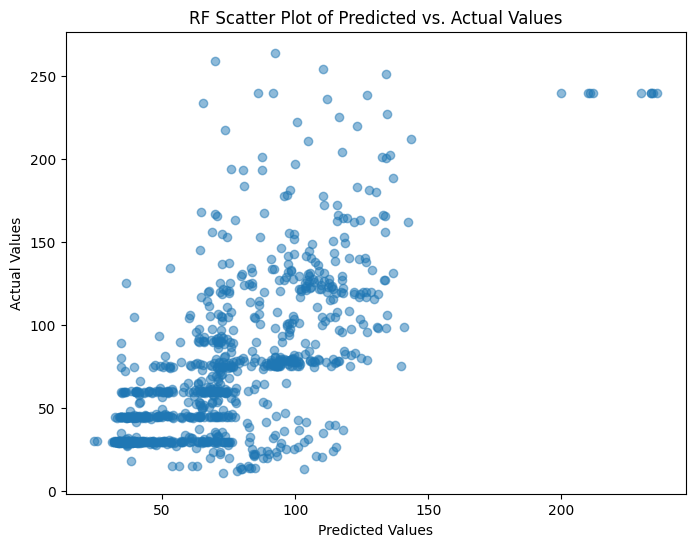

In [ ]:
plot_results(tuned_rf_predictions, 'RF')

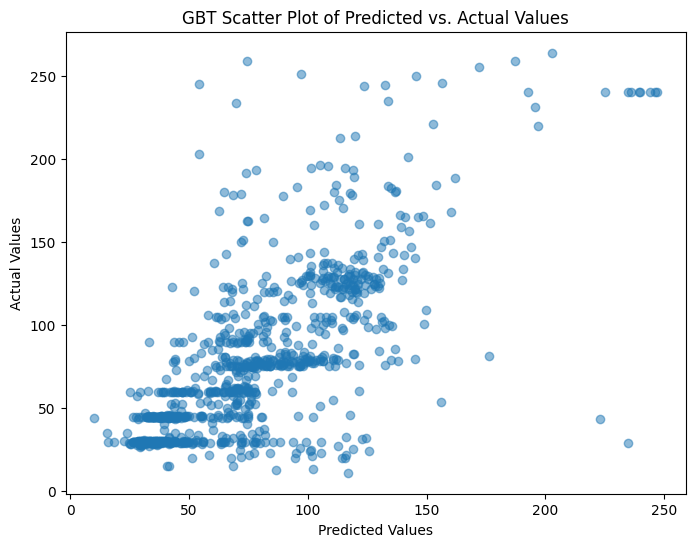

In [ ]:
plot_results(tuned_gbt_predictions, 'GBT')

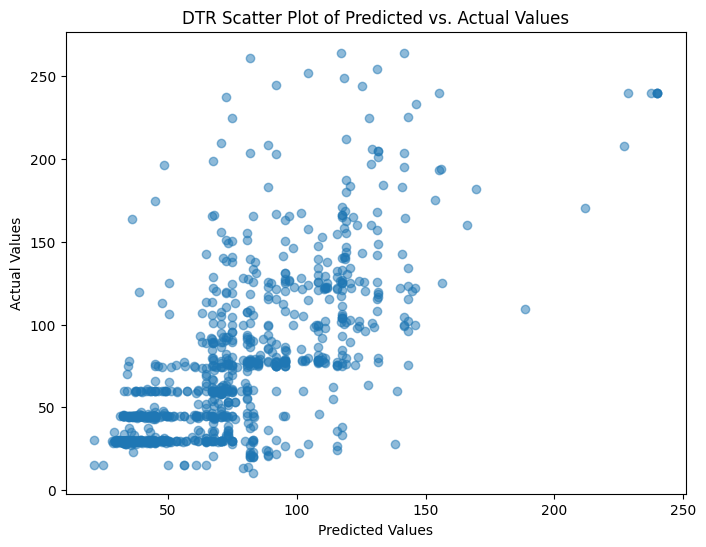

In [ ]:
plot_results(tuned_dtr_predictions, 'DTR')